# SEALS: A framework for building Self-Adaptive Virtual Machines

This notebook aim at providing the analysis process of the performances of Self-Adaptable Virtual Machines built with SEALS compared to an handwritten version of the same Self-Adaptable Virtual Machines.

## Imports

In [2]:
from os import listdir
from os.path import isfile, join
import math
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

## Data

Build the datastructure containing the results of the benchmarks. All the benchmarks were executed on a computer with 31Gb of RAM and an Intel(R) Core(TM) i7-10850H CPU (12 cores at 2.70GHz) with Manjaro 21.1.0. 
The SAVMs are run alone on the computer, and using GraalVM CE version 20.3.2 as JVM due to its necessity for the handcrafted HTML pretty-printer.
For each SAVM, we measure 30 program runs in a row repeated three times with reboot between each repetitions.

In [3]:
root_dir = './data/'

results=[]
for f in listdir(root_dir):
    path = join(root_dir, f)
    if isfile(path):
        fo = open(path)
        times = content = fo.readlines()
        splt = f.split('_')
        lang = splt[0]
        typ = splt[1]
        measureNb = splt[2][:-4]
        for (idx, time) in enumerate(times):
                results.append({
                        'lang': lang,
                        'type': typ,
                        'time': float(time),
                        'idx': idx * 3 + len(measureNb) - 1
                })

df = pd.DataFrame(results)
df.describe(include='all')

,lang,type,time,idx
count,540,540,540.000000,540.000000
unique,3,2,NaN,NaN
top,MiniJava,Handcraft,NaN,NaN
freq,180,270,NaN,NaN
mean,NaN,NaN,6.785424,44.500000
std,NaN,NaN,8.431195,26.003247
min,NaN,NaN,0.659000,0.000000
25%,NaN,NaN,0.930000,22.000000
50%,NaN,NaN,1.069500,44.500000
75%,NaN,NaN,15.298250,67.000000


## Statistic analysis

### Basic metrics

#### Variance

In [4]:
variances = pd.DataFrame(df.groupby(["lang", "type"]).time.var())
variances["lang"] = ""
variances["type"] = ""
variances.lang = variances.index.get_level_values(0)
variances.type = variances.index.get_level_values(1)
variances.index = range(6)
variances.rename(columns={"time":"Variances"}, inplace=True)

#### Standard deviation

In [5]:
deviations = pd.DataFrame(df.groupby(["lang", "type"]).time.std())
deviations["lang"] = ""
deviations["type"] = ""
deviations.lang = deviations.index.get_level_values(0)
deviations.type = deviations.index.get_level_values(1)
deviations.index = range(6)
deviations.rename(columns={"time":"Deviation"}, inplace=True)

#### Average time

In [6]:
means = pd.DataFrame(df.groupby(["lang", "type"]).time.mean())
means["lang"] = ""
means["type"] = ""
means.lang = means.index.get_level_values(0)
means.type = means.index.get_level_values(1)
means.index = range(6)
means.rename(columns={"time":"Mean"}, inplace=True)

#### Median value

In [7]:
medians = pd.DataFrame(df.groupby(["lang", "type"]).time.median())
medians["lang"] = ""
medians["type"] = ""
medians.lang = medians.index.get_level_values(0)
medians.type = medians.index.get_level_values(1)
medians.index = range(6)
medians.rename(columns={"time":"Median"}, inplace=True)

#### Concatenate all metrics

In [8]:
stats = pd.concat([variances, means, medians, deviations], axis=1)
stats["Variance"] = 0
stats.Variance = stats.Variances
del stats["Variances"]
stats = stats.loc[:,~stats.columns.duplicated()]
stats = stats.sort_values(['type', 'lang'])
stats.index = range(6)
stats

,lang,type,Mean,Median,Deviation,Variance
0,HTML,Framework,0.685267,0.6730,0.029439,0.000867
1,MiniJava,Framework,19.829233,18.0360,2.479150,6.146186
2,RobLANG,Framework,1.043844,1.0380,0.035087,0.001231
3,HTML,Handcraft,0.944022,0.9300,0.046143,0.002129
4,MiniJava,Handcraft,17.115256,15.3125,2.485714,6.178774
5,RobLANG,Handcraft,1.094922,1.0935,0.021523,0.000463


### Functions

compute_stats : print estimation of the mean and confidence interval of the data

In [9]:
def compute_stats(values):
    mean = np.mean(values)
    lo, hi = st.t.interval(0.95, df=(len(values) - 1), loc=mean, scale=st.sem(values))
    print("Estimated mean : " + str(mean))
    print("Confidence interval : [" + str(lo) + ", " + str(hi) + "] delta = " + str(mean - lo))



### Group data by Language and Type

In [10]:
Framework = df[df.type == "Framework"]
Handcraft = df[df.type == "Handcraft"]

frameworkHTML   = Framework[Framework.lang == "HTML"]
frameworkRobLANG  = Framework[Framework.lang == "RobLANG"]
frameworkMiniJava  = Framework[Framework.lang == "MiniJava"]

handcraftHTML   = Handcraft[Handcraft.lang == "HTML"]
handcraftRobLANG  = Handcraft[Handcraft.lang == "RobLANG"]
handcraftMiniJava  = Handcraft[Handcraft.lang == "MiniJava"]

### Get p-values

In [11]:
t_HTML,   p_HTML   = st.ttest_ind(a=handcraftHTML.time.tolist(),  b=frameworkHTML.time.tolist(),  equal_var=False)
t_RobLANG,  p_RobLANG  = st.ttest_ind(a=handcraftRobLANG.time.tolist(), b=frameworkRobLANG.time.tolist(), equal_var=False)
t_MiniJava,  p_MiniJava  = st.ttest_ind(a=handcraftMiniJava.time.tolist(), b=frameworkMiniJava.time.tolist(), equal_var=False)
pvalues = [p_HTML, p_RobLANG, p_MiniJava]

### Compute Effect Size (Cohen's d)

In [12]:
effectSize = stats.copy()
effectSize["P Values"] = 0
effectSize["Effect Size"] = 0
effectSize["Absolute Effect Size"] = 0
effectSize["Mean diff"] = 0
effectSize["Slowdown"] = 0

slowdownGeoMean = 1

for i in range(6):
  if effectSize.loc[i,"type"] == "Framework":
    SDpooled = math.sqrt((89*effectSize.loc[i+3,"Variance"]+89*effectSize.loc[i,"Variance"])/178)
    
    meanDiff = effectSize.loc[i+3,"Mean"]-effectSize.loc[i,"Mean"]
    slowdown = effectSize.loc[i,"Mean"] / effectSize.loc[i+3,"Mean"]
    effectSize.loc[i,"Effect Size"] = meanDiff / SDpooled
    effectSize.loc[i+3,"Effect Size"] = 0
    effectSize.loc[i,"Absolute Effect Size"] = abs(meanDiff / SDpooled)
    effectSize.loc[i+3,"Absolute Effect Size"] = 0
    effectSize.loc[i,"Mean diff"] = meanDiff
    effectSize.loc[i+3,"Mean diff"] = 0
    effectSize.loc[i,"Slowdown"] = slowdown
    effectSize.loc[i+3,"Slowdown"] = 0
    slowdownGeoMean = slowdownGeoMean * slowdown

del effectSize["Mean"]
del effectSize["Median"]
del effectSize["Variance"]
del effectSize["Deviation"]
effectSize = effectSize.groupby(["lang"]).sum()
effectSize["P Values"] = pvalues
effectSize["lang"] = ""
effectSize.lang = effectSize.index.get_level_values(0)
effectSize.index = range(3)

slowdownGeoMean = slowdownGeoMean ** (1. / 3) # cubic root

### Summary of the metrics

In [13]:
print("Stats for HTML build using the framework")  
compute_stats(frameworkHTML.time.tolist())

print("\nStats for RobLANG build using the framework")  
compute_stats(frameworkRobLANG.time.tolist())

print("\nStats for MiniJava build using the framework")  
compute_stats(frameworkMiniJava.time.tolist())

print("\n\nStats for HTML handcrafted")  
compute_stats(handcraftHTML.time.tolist())

print("\nStats for RobLANG handcrafted")  
compute_stats(handcraftRobLANG.time.tolist())

print("\nStats for MiniJava handcrafted")  
compute_stats(handcraftMiniJava.time.tolist())

print("\n\nMean slowdown (geometrical mean) : " + str(slowdownGeoMean))  

effectSize

Stats for HTML build using the framework
Estimated mean : 0.6852666666666667
Confidence interval : [0.6791008142759833, 0.69143251905735] delta = 0.006165852390683346

Stats for RobLANG build using the framework
Estimated mean : 1.0438444444444444
Confidence interval : [1.036495609922187, 1.0511932789667018] delta = 0.00734883452225743

Stats for MiniJava build using the framework
Estimated mean : 19.82923333333333
Confidence interval : [19.309985364588858, 20.348481302077804] delta = 0.5192479687444731


Stats for HTML handcrafted
Estimated mean : 0.9440222222222222
Confidence interval : [0.93435777706323, 0.9536866673812144] delta = 0.00966444515899223

Stats for RobLANG handcrafted
Estimated mean : 1.0949222222222224
Confidence interval : [1.0904144189717995, 1.0994300254726452] delta = 0.0045078032504228815

Stats for MiniJava handcrafted
Estimated mean : 17.115255555555557
Confidence interval : [16.594632856038277, 17.635878255072836] delta = 0.5206226995172791


Mean slowdown (ge

,P Values,Effect Size,Absolute Effect Size,Mean diff,Slowdown,lang
0,3.114497e-89,6.685704,6.685704,0.258756,0.725901,HTML
1,5.579223e-23,-1.093273,1.093273,-2.713978,1.158571,MiniJava
2,7.591006e-12,1.754889,1.754889,0.051078,0.953350,RobLANG


## Plots

### Summary of the benchmarks

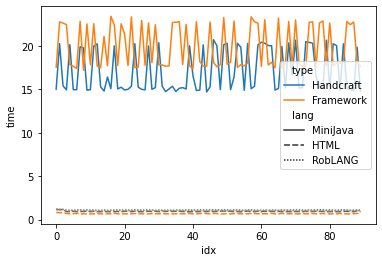

In [14]:
sns.lineplot(data=df, x="idx", y="time", hue="type", style="lang");

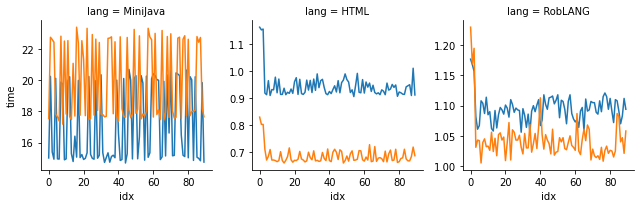

In [15]:
grid = sns.FacetGrid(df, col="lang", hue="type", sharey=False)
grid.map(sns.lineplot, "idx", "time");

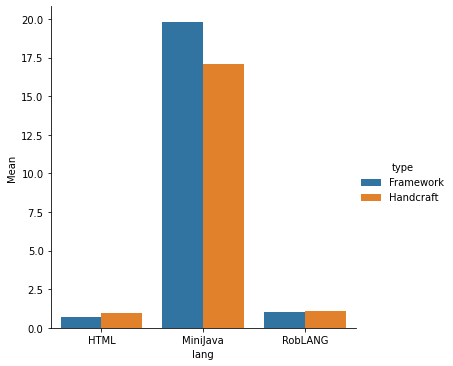

In [16]:
sns.catplot(x="lang", y="Mean", hue="type", kind="bar", data=means, sharex=False, legend_out=True);